## 100kmあたりのガソリン消費量の予測

### 0. データについて
- 使用するデータはKaggleの"Car Fuel Consumption"
##### 参考)https://www.kaggle.com/anderas/car-consume


- *note) E10の方が安価 E10 : 1.379€, SP98 : 1.459€*


|データ名|単位|意味|
|:-|:-|:-|
|distance|km|給油までの走行距離|
|consume|L/100km|100kmあたりのガソリン消費量|
|speed|km/h|平均速度|
|temp_inside|℃|車内設定温度|
|temp_outside|℃|給油時の外気温|
|specials|N/A|雨、雪、エアコンONのremark|
|gas_type|N/A|走行開始前に給油した油種（E10 or SP98)|
|AC|N/A|ONなら1。OFFなら0。|
|rain|N/A|雨か雪なら1。晴れなら0。|
|sun|N/A|晴れなら1。雨か雪なら0。|
|refill liters|L|給油した際の給油量|
|refill gas|N/A|給油した際の油種|

### 1. データの確認

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
%matplotlib inline

In [2]:
car = pd.read_csv("./DATA/measurements.csv",decimal=',') #データCSVの読み込み。decimalでカンマを変換

In [3]:
#データ確認
display(car.head())
car.info()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distance       388 non-null    float64
 1   consume        388 non-null    float64
 2   speed          388 non-null    int64  
 3   temp_inside    376 non-null    float64
 4   temp_outside   388 non-null    int64  
 5   specials       93 non-null     object 
 6   gas_type       388 non-null    object 
 7   AC             388 non-null    int64  
 8   rain           388 non-null    int64  
 9   sun            388 non-null    int64  
 10  refill liters  13 non-null     float64
 11  refill gas     13 non-null     object 
dtypes: float64(4), int64(5), object(3)
memory usage: 36.5+ KB


In [4]:
#欠損値数確認
print(car["temp_inside"].isnull().sum())
print(car["refill liters"].isnull().sum())

12
375


In [5]:
car.describe()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


### データについて分かったこと
- "temp_inside"に欠損値有り  
- "specials", "refill liters", "refill gas"は意味的に説明変数にならなそう。"refiill liters"と"refill gas"は次の走行に関する説明変数
- "gas_type"が文字列
- 値のスケールがバラバラ

### 2. 前処理
    1) temp_insideの前処理

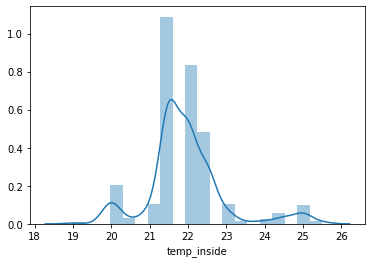

In [6]:
sns.distplot(car["temp_inside"], bins=20)
plt.show()

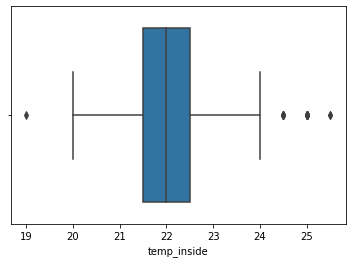

In [7]:
sns.boxplot(car["temp_inside"])
plt.show()

In [8]:
car["temp_inside"].value_counts()

21.5    133
22.0    102
22.5     59
20.0     25
23.0     13
21.0     13
25.0     12
24.5      7
20.5      4
24.0      3
25.5      2
23.5      2
19.0      1
Name: temp_inside, dtype: int64

- 19～25.5℃で分布しており異常値や外れ値もなさそう。
- 平均値で補完して良さそう

In [9]:
temp_inside_mod = car["temp_inside"].dropna() #NaNを削除
temp_inside_avg = temp_inside_mod.mean() #平均値算出
car["temp_inside"] = car["temp_inside"].fillna(temp_inside_avg)
car["temp_inside"].value_counts() #AVE 21.92...が入っているか？

21.500000    133
22.000000    102
22.500000     59
20.000000     25
23.000000     13
21.000000     13
21.929521     12
25.000000     12
24.500000      7
20.500000      4
24.000000      3
25.500000      2
23.500000      2
19.000000      1
Name: temp_inside, dtype: int64

    2) gas_typeの前処理

In [10]:
car["gas_type"].value_counts()

SP98    228
E10     160
Name: gas_type, dtype: int64

In [11]:
#SP98を0, E10を1に置換
car.loc[car["gas_type"]=="SP98", "gas_type"]=0
car.loc[car["gas_type"]=="E10", "gas_type"]=1
car["gas_type"]=car["gas_type"].astype(float)

    3) 不要列の削除
    - "specials", "refill liters", "refill gas"を削除

In [12]:
#使う変数だけでdf_carを作成
drop_columns = ["specials", "refill liters", "refill gas"]
df_car=car.drop(drop_columns, axis=1)

In [13]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   distance      388 non-null    float64
 1   consume       388 non-null    float64
 2   speed         388 non-null    int64  
 3   temp_inside   388 non-null    float64
 4   temp_outside  388 non-null    int64  
 5   gas_type      388 non-null    float64
 6   AC            388 non-null    int64  
 7   rain          388 non-null    int64  
 8   sun           388 non-null    int64  
dtypes: float64(4), int64(5)
memory usage: 27.4 KB


### 3. データの可視化

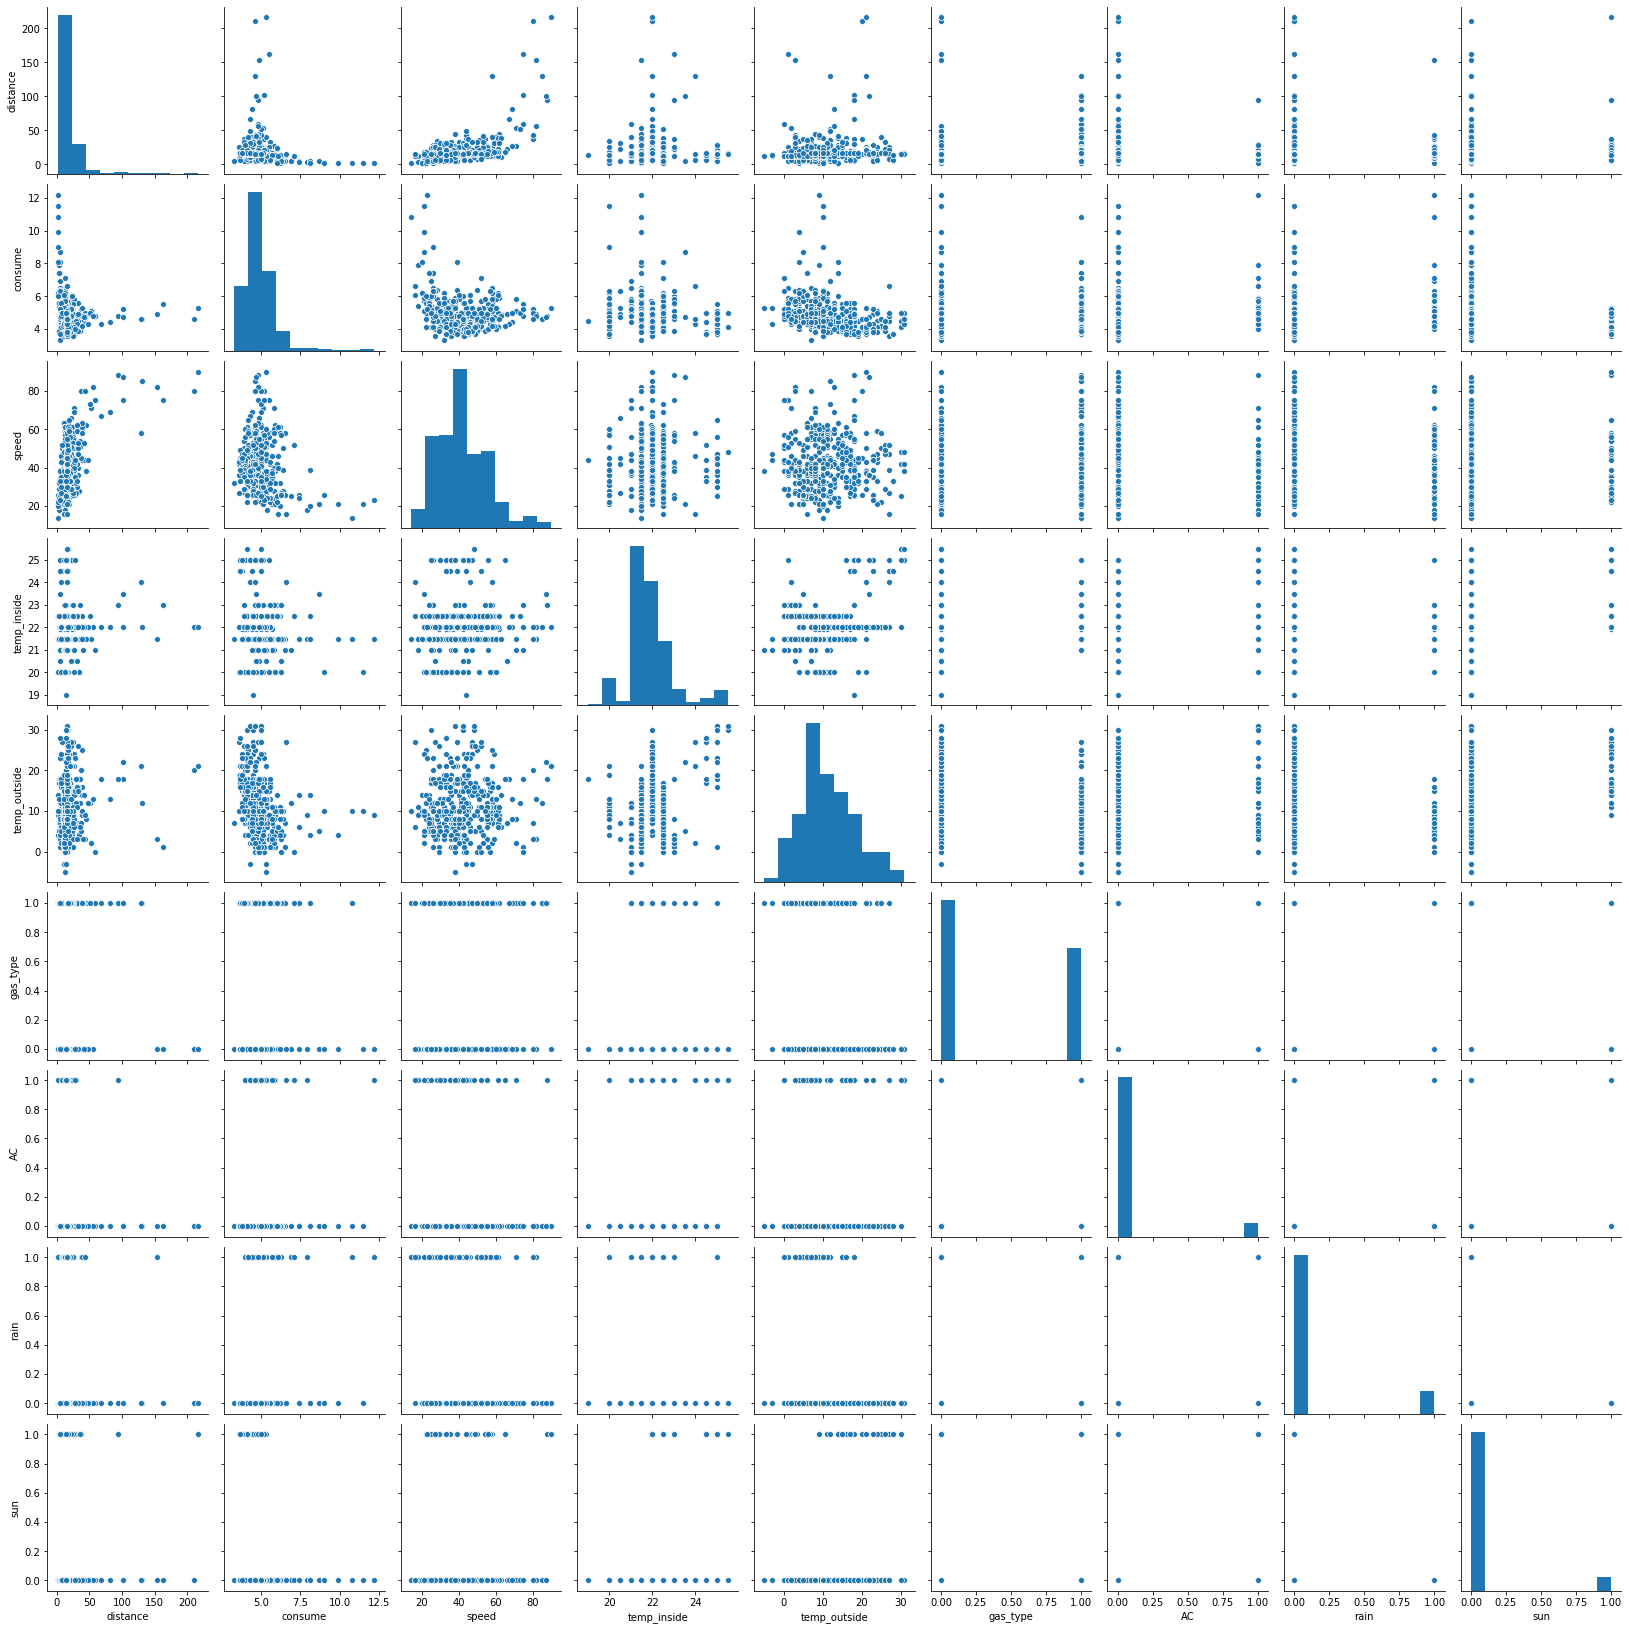

In [14]:
sns.pairplot(df_car)
plt.show()

In [15]:
df_car.corr()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,0.053411,-0.025738,-0.019791,0.081120
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.015327,0.096591,0.248118,-0.170667
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,0.097360,-0.035408,0.009489,0.081618
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,-0.010198,0.297376,-0.036937,0.242248
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,-0.148705,0.167562,-0.186315,0.346903
gas_type,0.053411,0.015327,0.097360,-0.010198,-0.148705,1.000000,-0.105285,-0.060328,-0.022761
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,-0.105285,1.000000,0.242915,0.088598
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,-0.060328,0.242915,1.000000,-0.112650
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,-0.022761,0.088598,-0.112650,1.000000


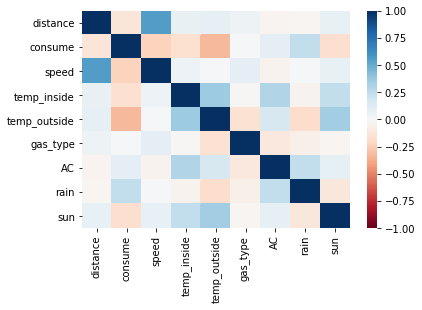

In [16]:
sns.heatmap(df_car.corr(),cmap='RdBu',vmin=-1,vmax=1)
plt.show()

### 4. モデル作成
- note) Day1では線形回帰にてモデル作成　訓練誤差はMSE = 0.845、RMSE = 0.919、MAE = 0.618

- 線形回帰モデルを交差検証法にて評価
- 説明変数は標準化しておく

    **2値の説明変数があるが標準化して大丈夫？？？**

In [17]:
# 変数の設定
y = df_car["consume"].values
x = df_car[["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun", "gas_type"]].values #ここをセンス良く書きたい

# ------ここまで------------ notebookの１をよく読む

(array([311.,  59.,   7.,   2.,   3.,   1.,   1.,   2.,   0.,   2.]),
 array([-0.81068748,  0.13813416,  1.0869558 ,  2.03577745,  2.98459909,
         3.93342074,  4.88224238,  5.83106402,  6.77988567,  7.72870731,
         8.67752895]),
 <a list of 10 Patch objects>)

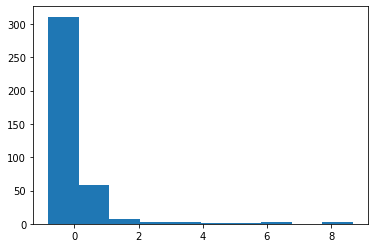

In [18]:
#説明変数の標準化
from sklearn.preprocessing import StandardScaler, MinMaxScaler
stdsc = StandardScaler()
X= stdsc.fit_transform(x)
plt.hist(X[:, 0]) #標準化後の1つ目の特徴に関するヒストグラム

In [19]:
#交差検証法
from sklearn.model_selection import KFold # 交差検証法に関する関数

y = y.reshape(-1,1) # scikit-learnに入力するために整形 ←ここ？？？
n_split = 5 # グループ数を設定（5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # 予測を実行
    y_pred_train = regr.predict(X_train)
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE_train = %s"%round(mae_train, 3))
    print("MAE_test  = %s"%round(mae_test, 3))
    print()
    
    cross_valid_mae += mae_test #後で平均を取るためにMAEを加算
    split_num += 1

Fold 1
MAE_train = 0.616
MAE_test  = 0.666

Fold 2
MAE_train = 0.629
MAE_test  = 0.619

Fold 3
MAE_train = 0.568
MAE_test  = 0.742

Fold 4
MAE_train = 0.625
MAE_test  = 0.61

Fold 5
MAE_train = 0.65
MAE_test  = 0.518



In [20]:
# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Cross Validation MAE = 0.631


### 訓練誤差と汎化誤差に大きく差はなくオーバーフィッティングは起こっていない
### 正則化は不要